# Analyse et classification de posts Reddit provenant de Subreddit sur l'autisme

- Configuration & import

In [45]:
# Import librairies needed for this project
import warnings
warnings.filterwarnings("ignore")

from utils.authentification_token import string_connection
from sqlalchemy import create_engine
import psycopg2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter


import gc

import nltk
nltk.download("stopwords")
from utils.nlp_utils_autism import remove_stopwords, normalize_corpus, plot_top_words
import sklearn
from sklearn.feature_extraction.text import  TfidfVectorizer

from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from gensim.corpora.dictionary import Dictionary
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel

import mlflow

[nltk_data] Downloading package stopwords to /home/cecile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
# Configuration display

sklearn.set_config(display="diagram")

## 1) Nettoyage

In [47]:
STRING_CONNECTION = string_connection
engine = create_engine(STRING_CONNECTION)

In [48]:
df = pd.read_sql("reddit_extraction", 
                 con=engine)
df.head()

,index,title,score,id,url,num_comments,text,subreddit_name
0,2,"Dear *those* autistic men,",345,13h5ymk,https://www.reddit.com/r/autism/comments/13h5y...,123,Our lives aren't automatically better then you...,Autism
1,3,You only accept it as long as it doesn’t incon...,1085,13gyesp,https://i.redd.it/doeb5enynqza1.jpg,48,None,Autism
2,4,Yeah basically.,434,13gxkud,https://i.redd.it/vkm7vfz1hqza1.jpg,8,None,Autism
3,5,"""i feel like neurotypical people actually enjo...",807,13gsoty,https://i.redd.it/yc7a52r8ynza1.png,37,None,Autism
4,6,"Or, if I have different colors, I have to eat ...",425,13gxlkt,https://i.redd.it/lai29qz7hqza1.jpg,16,None,Autism


In [49]:
df.drop_duplicates('id',
                   inplace=True)

In [50]:
df.dropna(inplace=True, how="any")
df.shape

(8628, 8)

## 2) Analyse de données

### a) Analyse quantitative

#### Analyse univariée

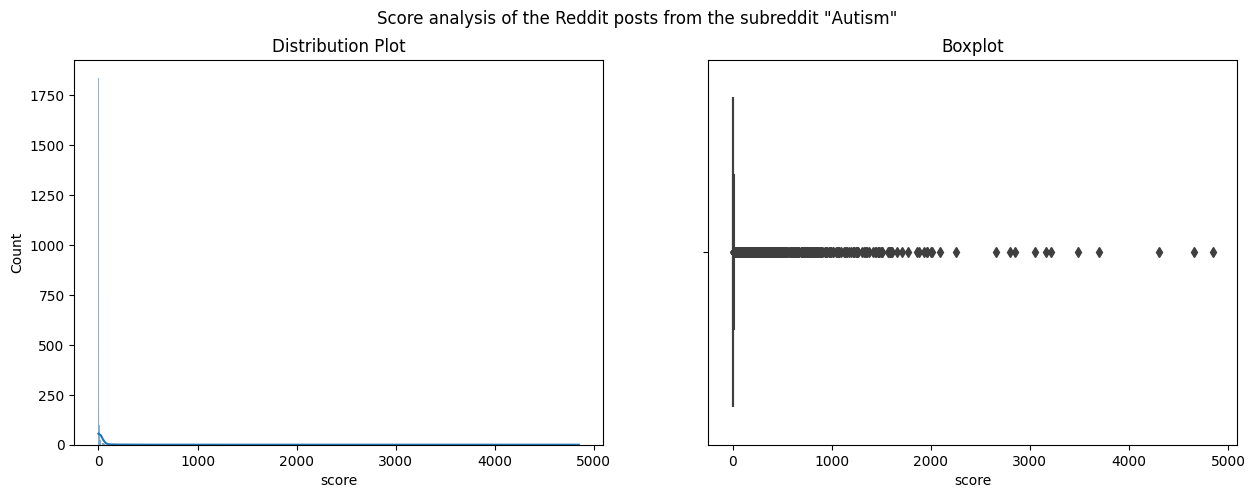

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Score analysis of the Reddit posts from the subreddit "Autism"')

sns.histplot(ax=axes[0], x="score", data=df, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="score", data=df)
axes[1].set_title("Boxplot")

plt.show()

In [52]:
print("Mean score:", (np.mean(df["score"])).round(2))
print("Median score:", np.median(df["score"]))

Mean score: 39.09
Median score: 3.0


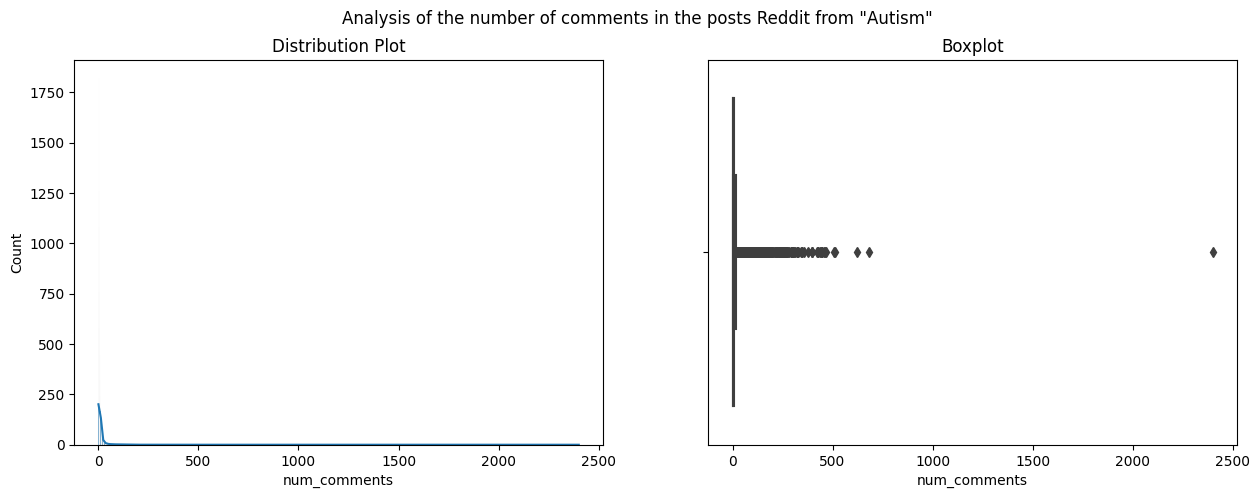

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Analysis of the number of comments in the posts Reddit from "Autism"')

sns.histplot(ax=axes[0], x="num_comments", data=df, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="num_comments", data=df)
axes[1].set_title("Boxplot")

plt.show()

In [54]:
print("Mean number of comments: ", (np.mean(df["num_comments"]).round(2)))
print("Median number of comments: ", np.median(df["num_comments"]))

Mean number of comments:  12.38
Median number of comments:  3.0


#### Analyse bivariée

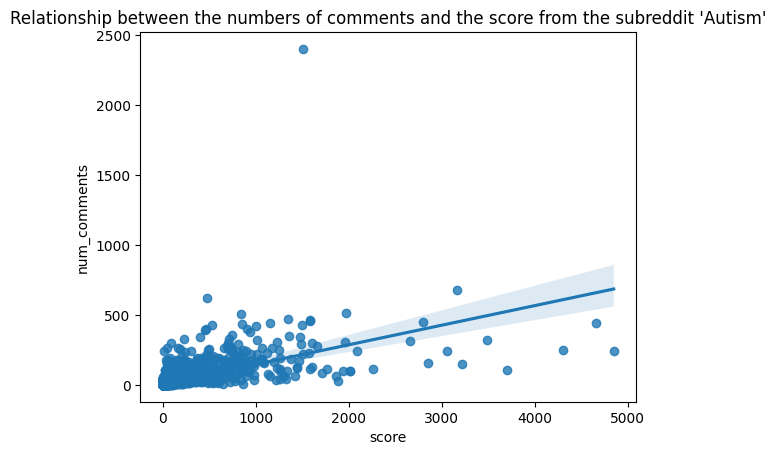

In [55]:
sns.regplot(x="score",
            y="num_comments",
            data=df)
plt.title("Relationship between the numbers of comments and the score from the subreddit 'Autism'")
plt.show()

Now, the text analysis begin. It is separated in two parts : 
- one part about the title
- one part about the text (when it exists)

### b) Analyse textuelle

#### Analyse du contenu des titres

In [56]:
df_title = df[["id","title"]]
df_title.head()

,id,title
0,13h5ymk,"Dear *those* autistic men,"
6,13h6s7n,I am a server. I waited on someone with autism...
7,13h3c1h,"The Love of my life, while on the spectrum…"
9,13h3wzn,DJing has been a great way for me to share one...
10,13gpg1j,It makes me extremely angry that we don’t have...


In [57]:
df_title["title_norm"] = normalize_corpus(df_title["title"])
df_title.head()

,id,title,title_norm
0,13h5ymk,"Dear *those* autistic men,",dear man
6,13h6s7n,I am a server. I waited on someone with autism...,I server I wait stop
7,13h3c1h,"The Love of my life, while on the spectrum…",love life
9,13h3wzn,DJing has been a great way for me to share one...,djing great I share special interest stim freely
10,13gpg1j,It makes me extremely angry that we don’t have...,I extremely angry male sa statistic


In [58]:
vectorizer_tf = TfidfVectorizer()

tfidf_title = vectorizer_tf.fit_transform(df_title['title_norm']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_title_tf = pd.DataFrame(tfidf_title, columns=feature_names)
df_title_tf = pd.DataFrame(df_title_tf.mean(), columns=["Value"])
df_title_tf = df_title_tf.sort_values("Value",ascending=False)
df_title_tf = df_title_tf.head(30)
df_title_tf = df_title_tf.sort_values("Value", ascending=True)

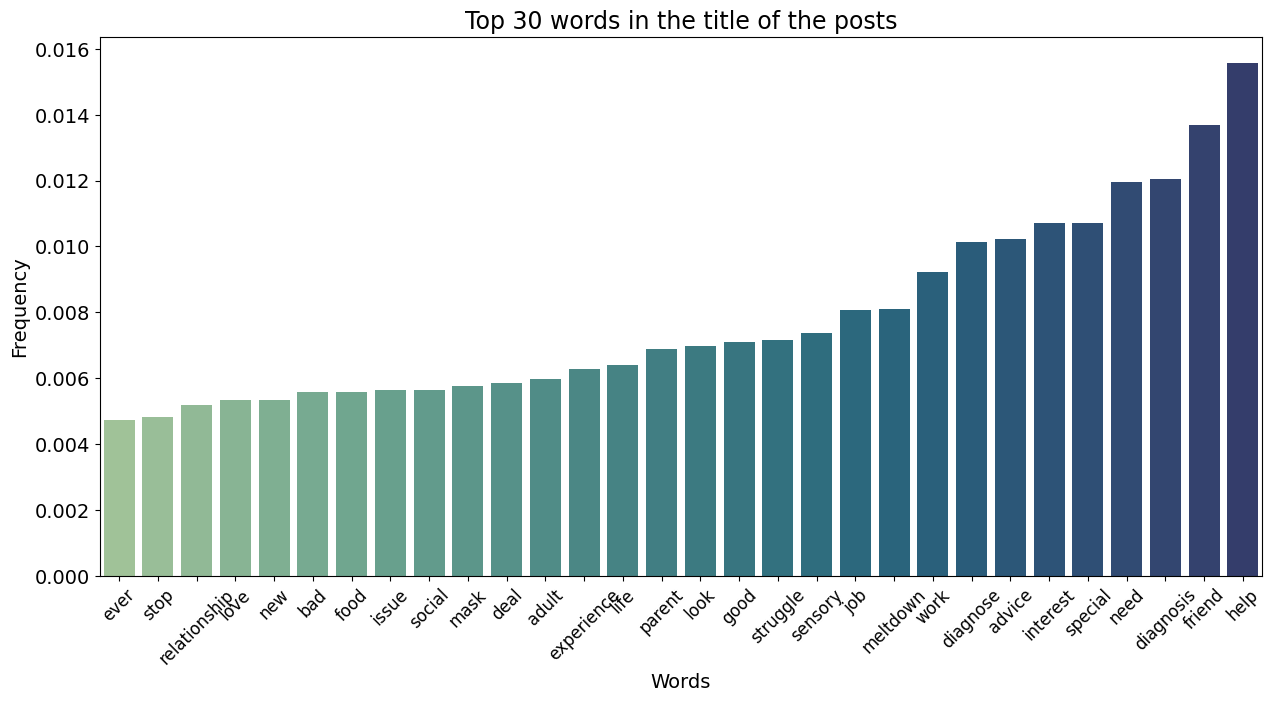

In [59]:
fig = plt.figure(figsize = (15, 7))

g = sns.barplot(
    x = df_title_tf.index,
    y = df_title_tf["Value"],
    data = df_title_tf,
    palette = 'crest'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title("Top 30 words in the title of the posts", fontsize = 17)

plt.show()

#### Analyse du contenu des posts

In [60]:
df_text = df[["id","text"]]

In [61]:
df_text["text_norm"] = normalize_corpus(df_text["text"])
df_text.head()

,id,text,text_norm
0,13h5ymk,Our lives aren't automatically better then you...,life automatically well stuggle girlfriend stu...
6,13h6s7n,I (20M) work at a popular soul food chain in t...,I work popular soul food chain southeast part ...
7,13h3c1h,"Ever since I was 11 years old, I’ve always wan...",ever since I year old I girlfriend yes ik youn...
9,13h3wzn,I have been DJing for about 5 years and am now...,I dj year gig I actually enjoy I share small v...
10,13gpg1j,9/10 Afab autistic people get SAed in their li...,afab saed lifetime I attempt amab statistic si...


In [62]:
vectorizer_tf = TfidfVectorizer()
tfidf_text = vectorizer_tf.fit_transform(df_text['text_norm']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_text_tf = pd.DataFrame(tfidf_text, columns=feature_names)
df_text_tf = pd.DataFrame(df_text_tf.mean(), columns=["Value"])
df_text_tf = df_text_tf.sort_values("Value",ascending=False)
df_text_tf = df_text_tf.head(30)
df_text_tf = df_text_tf.sort_values("Value", ascending = True)

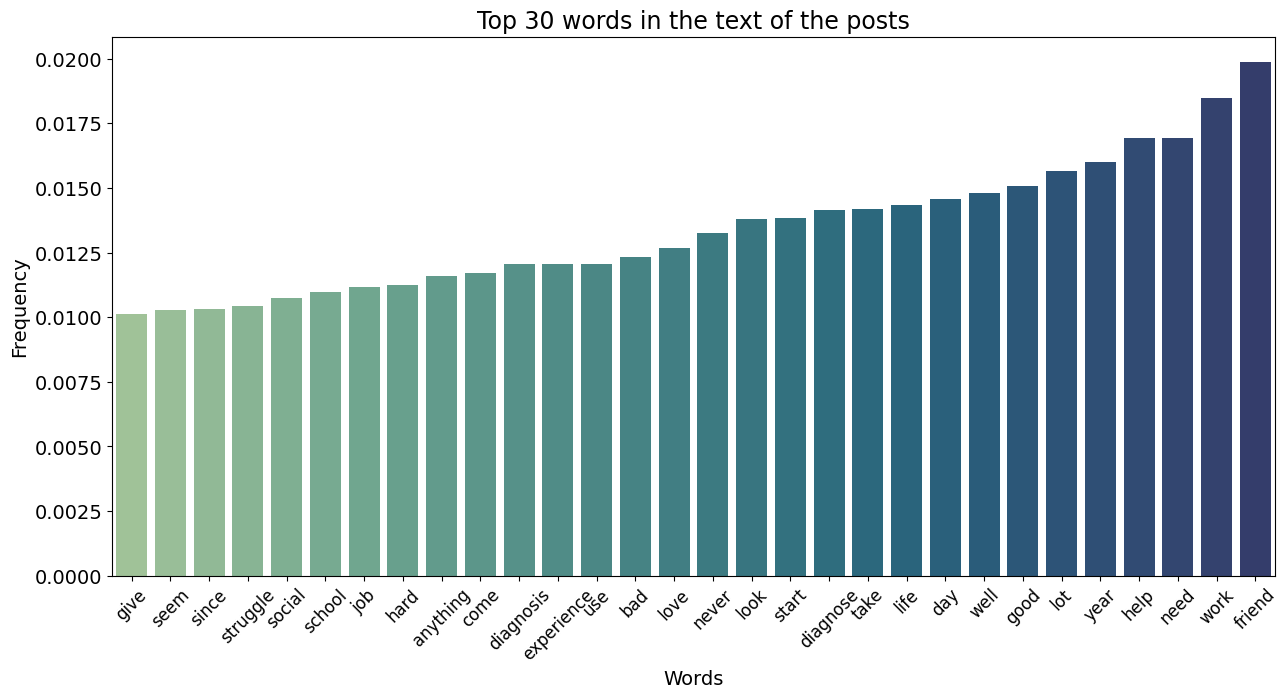

In [63]:
fig = plt.figure(figsize = (15, 7))

g = sns.barplot(
    x = df_text_tf.index,
    y = df_text_tf["Value"],
    data = df_text_tf,
    palette = 'crest'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title("Top 30 words in the text of the posts", fontsize = 17)

plt.show()

## 3) Topic modeling

- Prépartion des données

In [64]:
docs = df_title["title_norm"] + " " + df_text["text_norm"]

In [65]:
docs = docs.values.astype('U')

In [66]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [67]:
data_dense = tfidf.todense()
print("Sparsicity: ", (((data_dense > 0).sum()/data_dense.size)*100).round(3), "%")

Sparsicity:  0.22 %


- Modélisation via NMF

In [68]:
dataset = [d.split() for d in docs]
common_dictionary = Dictionary(dataset)
corpus = [common_dictionary.doc2bow(text) for text in dataset]

In [69]:
topic_nums = list(np.arange(5, 10 + 1, 1))
coherence_scores = []

In [70]:
for num in topic_nums:
    nmf = Nmf(
        corpus = corpus,
        num_topics = num, 
        id2word=common_dictionary,
        chunksize = 2000,
        normalize = True,
        random_state = 42
    )

    cm = CoherenceModel(
        model = nmf,
        texts = dataset,
        dictionary=common_dictionary,
        coherence = 'c_v'
    )

    coherence_scores.append(round(cm.get_coherence(), 5))

In [71]:
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

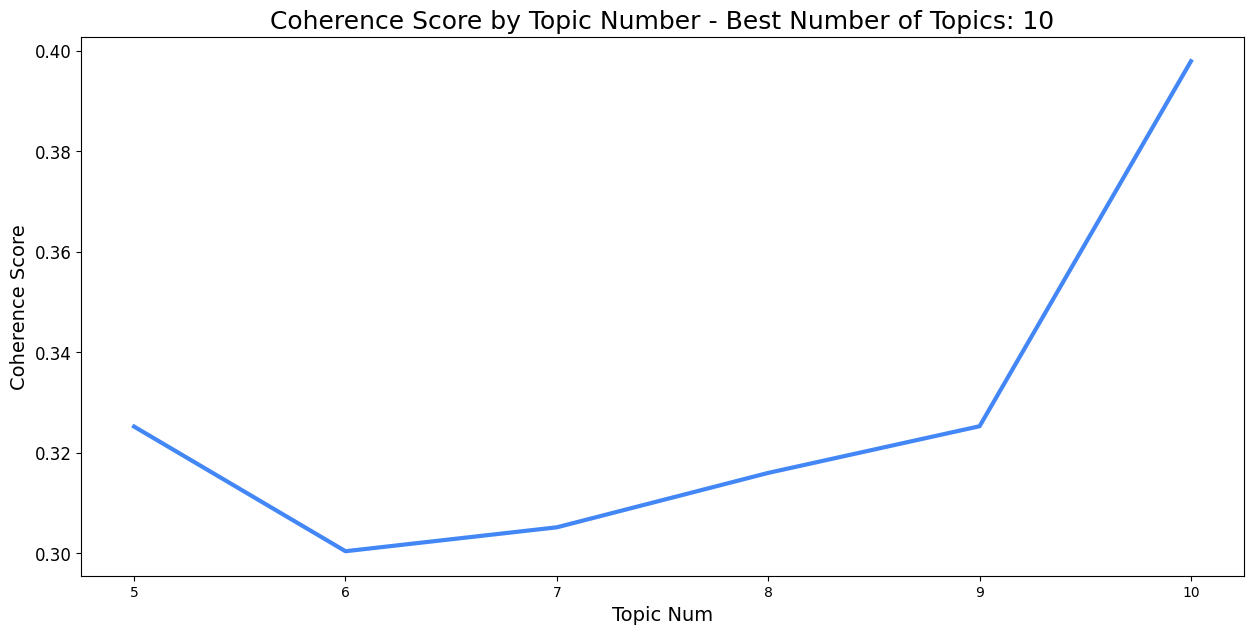

In [72]:
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth = 3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.yticks(fontsize=12)

plt.show()

In [73]:
nmf = NMF(n_components = 10,
          random_state = 42)
nmf.fit(tfidf)

2023/06/23 22:06:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '04ef8b1da6b342fc9ee6434a77290275', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


: 

: 

- Visualisation du résultat

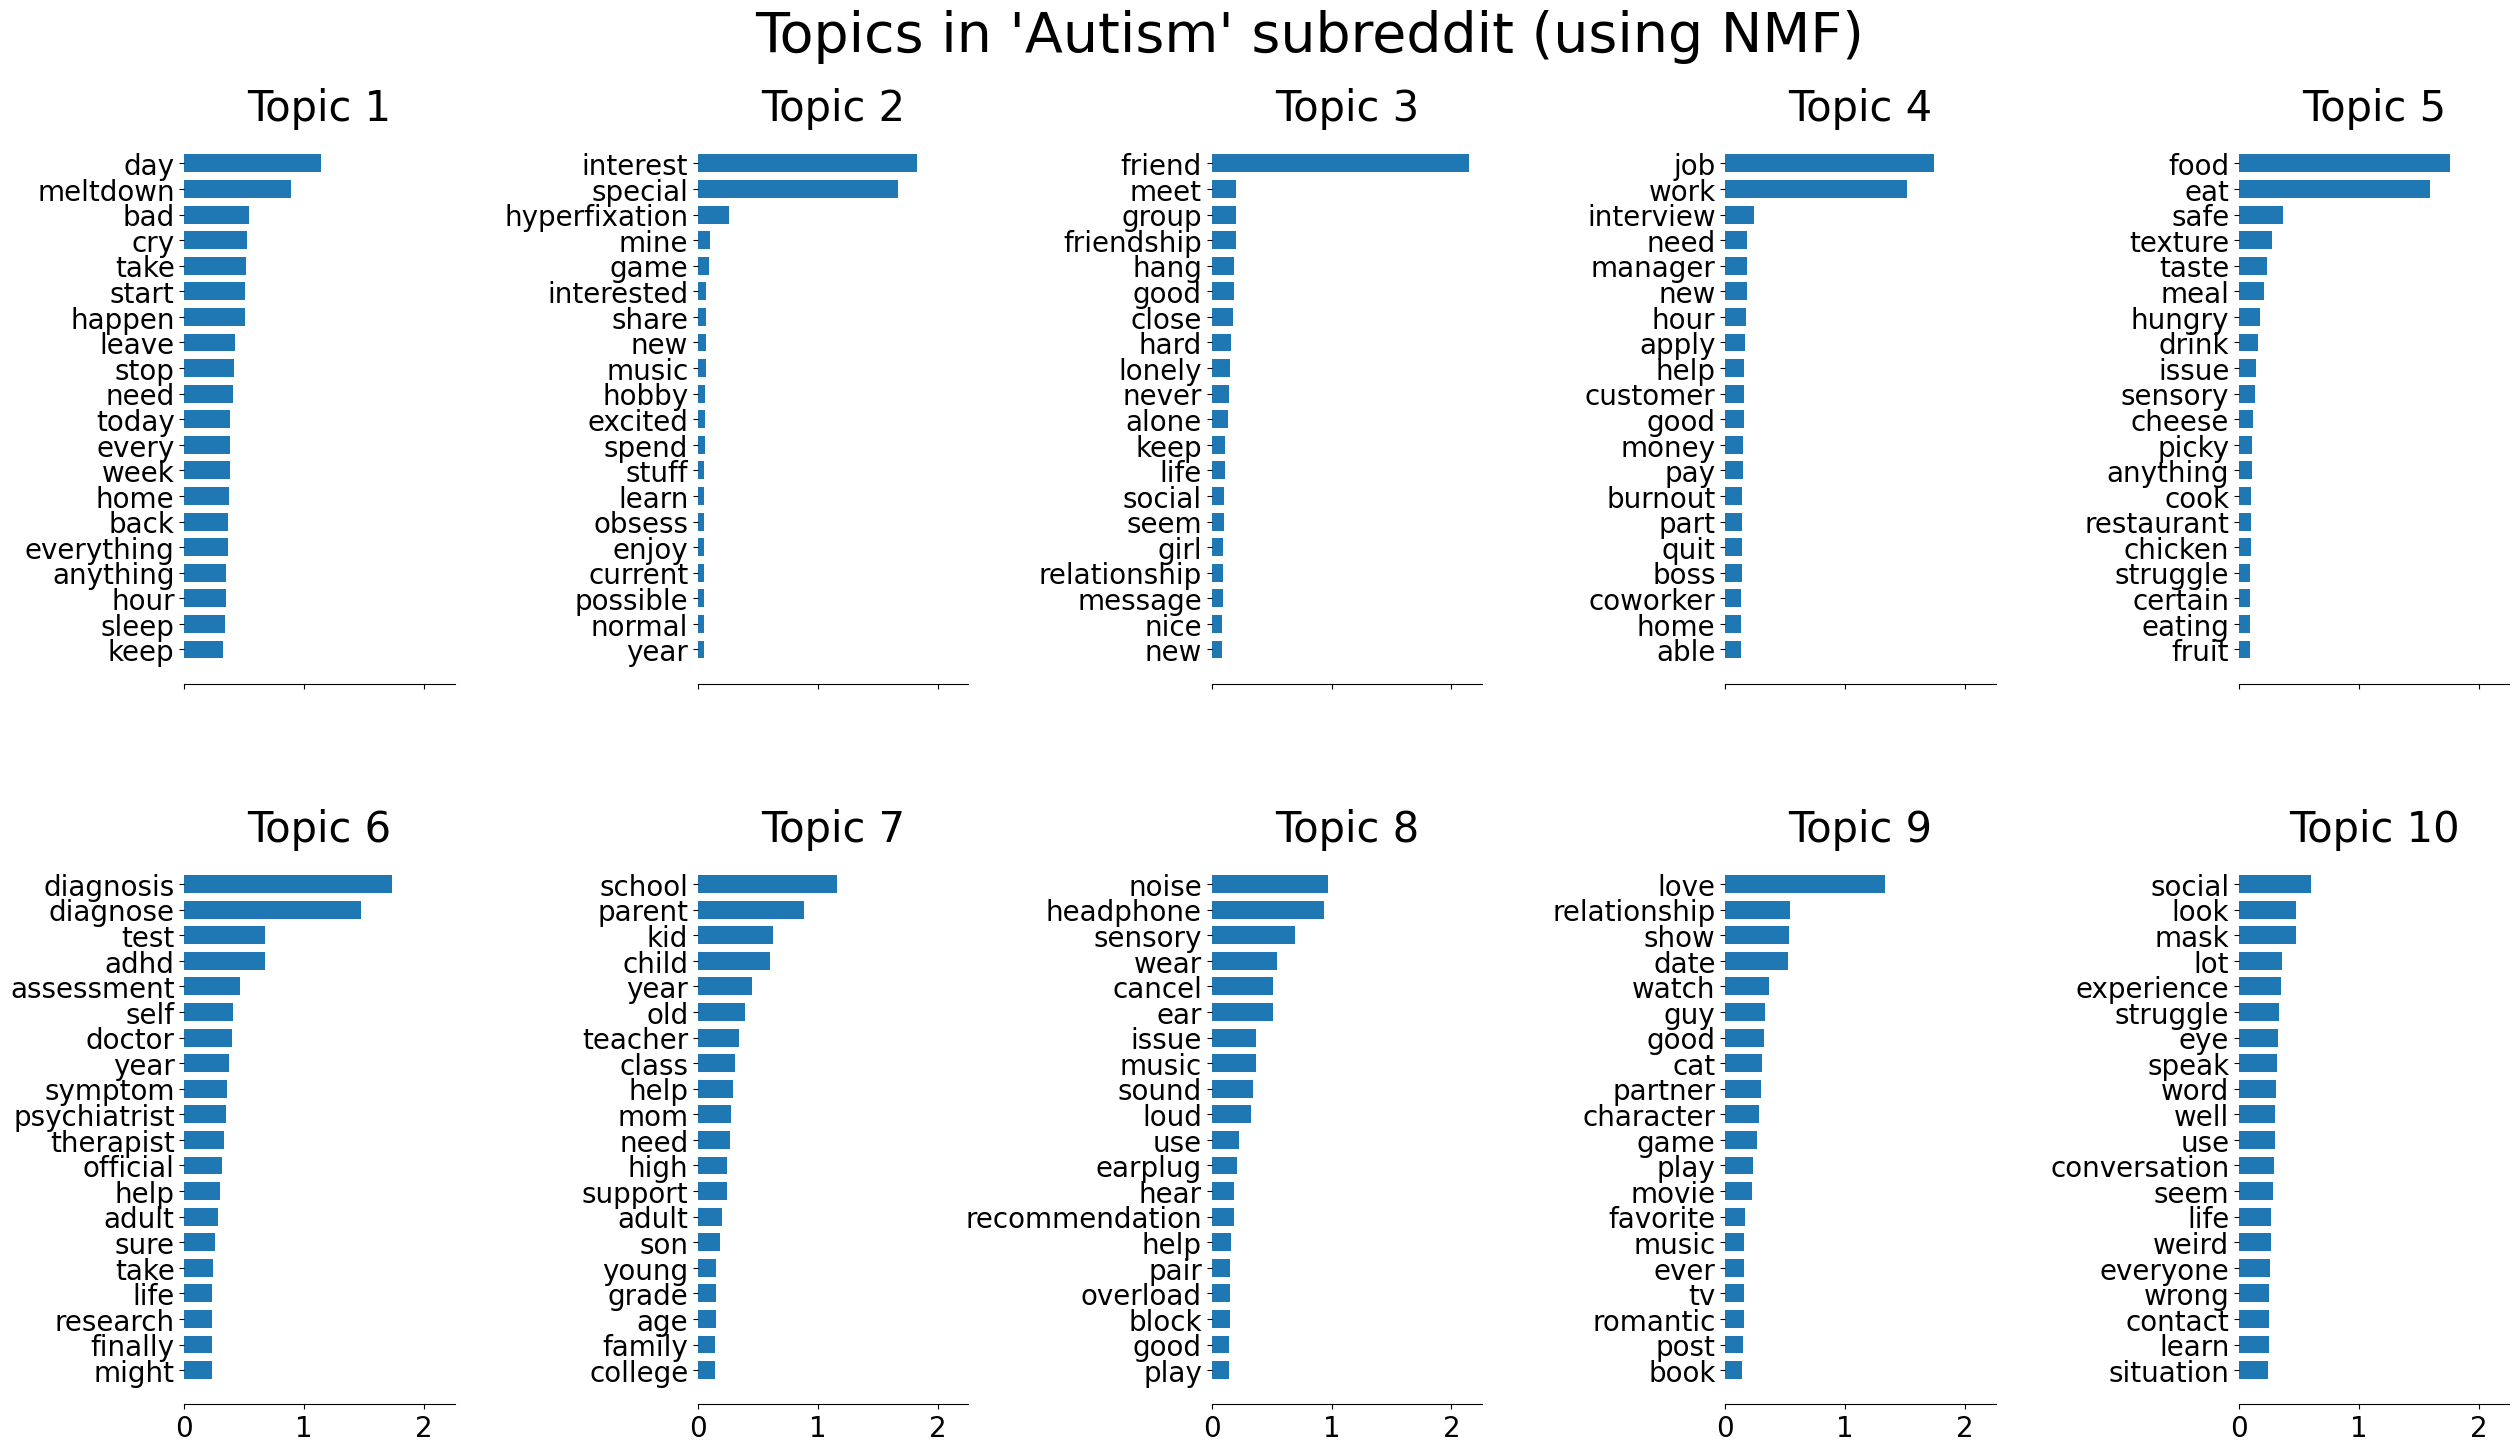

In [ ]:
plot_top_words(nmf, 
               tfidf_feature_names, 
               n_top_words = 20, 
               title = "Topics in 'Autism' subreddit (using NMF)")

- Thématique 1 : Vie quotidienne
- Thématique 2 : Intérêts spécifiques
- Thématique 3 : Amitié
- Thématique 4 : Travail
- Thématique 5 : Alimentation
- Thématique 6 : Santé (mentale) & Comorbidités
- Thématique 7 : Education
- Thématique 8 : Bruit
- Thématique 9 : Relations amoureuses
- Thématique 10 : Interactions sociales et communications

## 4) Etiquettage des données

In [ ]:
df["title_&_text_norm"] = df_title["title_norm"] + " " + df_text["text_norm"] 

In [ ]:
df.head()

,index,title,score,id,url,num_comments,text,subreddit_name,title_&_text_norm
0,2,"Dear *those* autistic men,",345,13h5ymk,https://www.reddit.com/r/autism/comments/13h5y...,123,Our lives aren't automatically better then you...,Autism,dear man life automatically well stuggle girlf...
6,8,I am a server. I waited on someone with autism...,34,13h6s7n,https://www.reddit.com/r/autism/comments/13h6s...,5,I (20M) work at a popular soul food chain in t...,Autism,I server I wait stop I work popular soul food ...
7,9,"The Love of my life, while on the spectrum…",49,13h3c1h,https://i.redd.it/fvtm8ox7vrza1.jpg,2,"Ever since I was 11 years old, I’ve always wan...",Autism,love life ever since I year old I girlfriend y...
9,11,DJing has been a great way for me to share one...,40,13h3wzn,https://v.redd.it/h34jtui61sza1,6,I have been DJing for about 5 years and am now...,Autism,djing great I share special interest stim free...
10,12,It makes me extremely angry that we don’t have...,219,13gpg1j,https://www.reddit.com/r/autism/comments/13gpg...,47,9/10 Afab autistic people get SAed in their li...,Autism,I extremely angry male sa statistic afab saed ...


In [ ]:
def topic_table(n_top_words, feature_names, nmf):
  topics = {}
  for i, topic_vec in enumerate(nmf.components_):
    topic_descr = ''
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
      topic_descr = topic_descr + feature_names[fid] + " "
    topics[i] = topic_descr
  return pd.DataFrame({'Top_Topic_Terms': topics})

In [ ]:
topic_df = topic_table(5, tfidf_vectorizer.get_feature_names_out(), nmf)

topic_df['Label'] = ['Vie quotidienne', 'Intérêts spécifiques', 
                     'Amitié', 'Travail',
                     'Alimentation', 'Santé',
                     'Education', "Bruit",
                     'Relations amoureuses', 'Communication']
document_weights = nmf.transform(tfidf_vectorizer.transform(df['title_&_text_norm'].astype('U')))

df["Topic_Number"] = document_weights.argmax(axis=1)
df = pd.merge(df, 
              topic_df, 
              left_on='Topic_Number', 
              right_index=True, 
              how='left')

## 5) Classification des posts

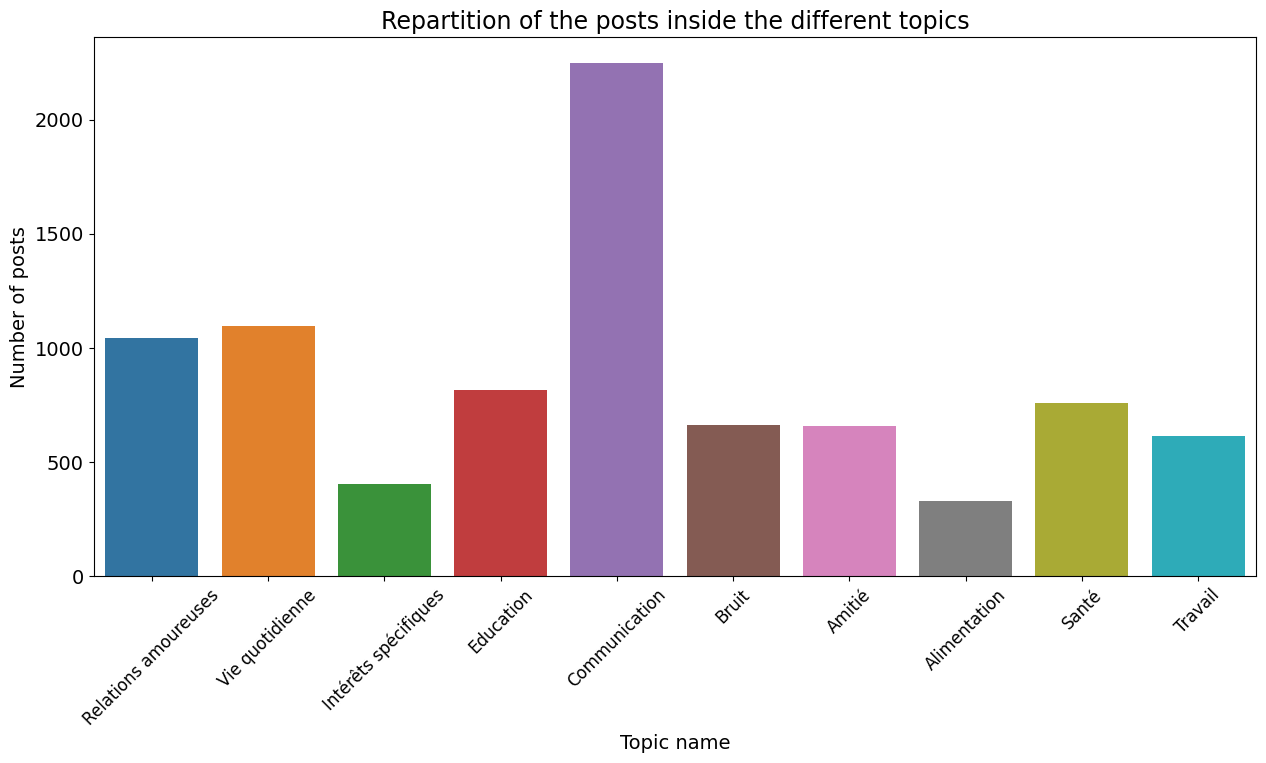

In [ ]:
fig = plt.figure(figsize=(15, 7))

g = sns.countplot(x = "Label",
              data = df)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12)


plt.yticks(fontsize = 14)
plt.xlabel("Topic name", fontsize = 14)
plt.ylabel("Number of posts", fontsize = 14)
plt.title("Repartition of the posts inside the different topics", fontsize = 17)

plt.show()

In [ ]:
df.drop(["id", "title", "text", 
         "Top_Topic_Terms", "score",
         "url", "num_comments", "subreddit_name", "index"], 
        axis = 1,
        inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, 
                                     test_size=0.25, 
                                     random_state=42)

y_train = train_set[["Topic_Number"]]
y_test = test_set[["Topic_Number"]]
X_train = train_set.drop(["Label","Topic_Number"], axis = 1)
X_test = test_set.drop(["Label","Topic_Number"], axis = 1)

In [ ]:
len(X_train), len(X_test)

(6471, 2157)

In [ ]:
X_train.head()

,title_&_text_norm
5491,work appropriate sensory friendly pant I apply...
4958,story ok awareness month good month tbh close ...
11353,ever randomly frustrate deal I frustrated I qu...
2001,wrong self diagnosing I probably lot heat hear...
2920,need valid communicate happy I diagnose almost...


In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train['title_&_text_norm'].astype('U'))
X_train_vec = tfidf.transform(X_train['title_&_text_norm'].astype('U'))
X_test_vec = tfidf.transform(X_test['title_&_text_norm'].astype('U'))

In [ ]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("reddit-classifier")

2023/06/23 12:17:41 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/23 12:17:41 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/cecile/Documents/Reddit-Analysis/reddit-nlp-analysis/mlruns/1', creation_time=1687032775263, experiment_id='1', last_update_time=1687032775263, lifecycle_stage='active', name='reddit-classifier', tags={}>

In [ ]:
mlflow.sklearn.autolog()

with mlflow.start_run():
    mlflow.set_tag("developper", "cecile")
    n_estimators = 200
    mlflow.log_param("n_estimators", n_estimators)
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                random_state=42)
    rf.fit(X_train_vec, y_train)

    y_pred = rf.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

2023/06/23 12:17:44 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'toarray'
2023/06/23 12:18:00 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: too many indices for array: array is 2-dimensional, but 3 were indexed


In [ ]:
print("Accuracy Score: ", round(accuracy, 5) * 100, "%")

Accuracy Score:  77.886 %


(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

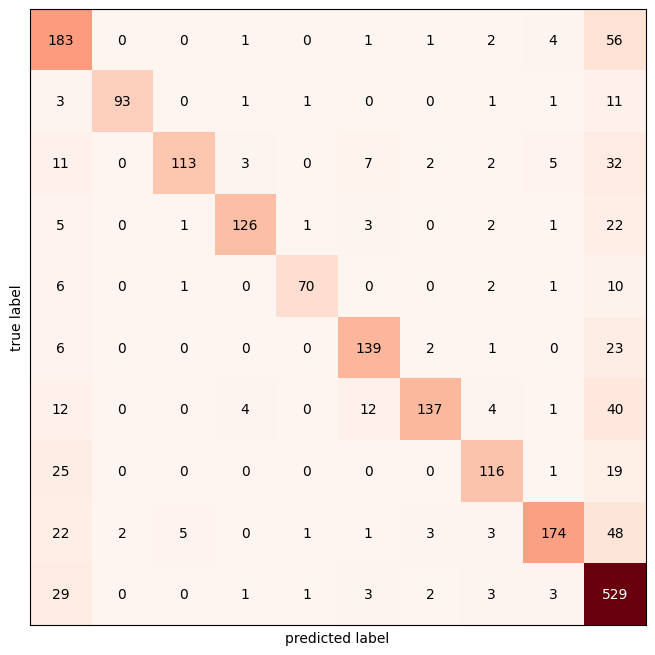

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, figsize = (12,8), hide_ticks = True, cmap=plt.cm.Reds)